In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install alpha_vantage

# ***Importing Libraries***

In [3]:
import numpy as np
import pandas as pd
import datetime
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import pickle

# ***Data Loading***

<font color='Orange'> **Generated the API Key From Here:** https://www.alphavantage.co/support/#api-key

In [4]:
# Data loading
api_key = 'SJFEIRZEBD8J7ULJ'
symbol = 'IBM' #IBM stock symbol
ts = TimeSeries(key=api_key, output_format='pandas')

In [5]:
try:
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
except ValueError as e:
    print(f"Error fetching data: {e}")
    data = None

# ***Data Preprocessing***

In [6]:
if data is not None:
    data = data[['4. close']].rename(columns={'4. close': 'Close'})
    data = data.iloc[::-1]  # Reverse to have oldest to newest

    # Filter last 5 years
    five_years_ago = datetime.datetime.now() - datetime.timedelta(days=10*365)
    data = data[data.index >= five_years_ago.strftime('%Y-%m-%d')]
else:
    print("No data fetched. Please check the API key and symbol.")

print("Data loaded successfully.")
print(data.head())

Data loaded successfully.
             Close
date              
2014-11-19  161.43
2014-11-20  160.64
2014-11-21  160.92
2014-11-24  162.15
2014-11-25  161.76


# ***Visualization***

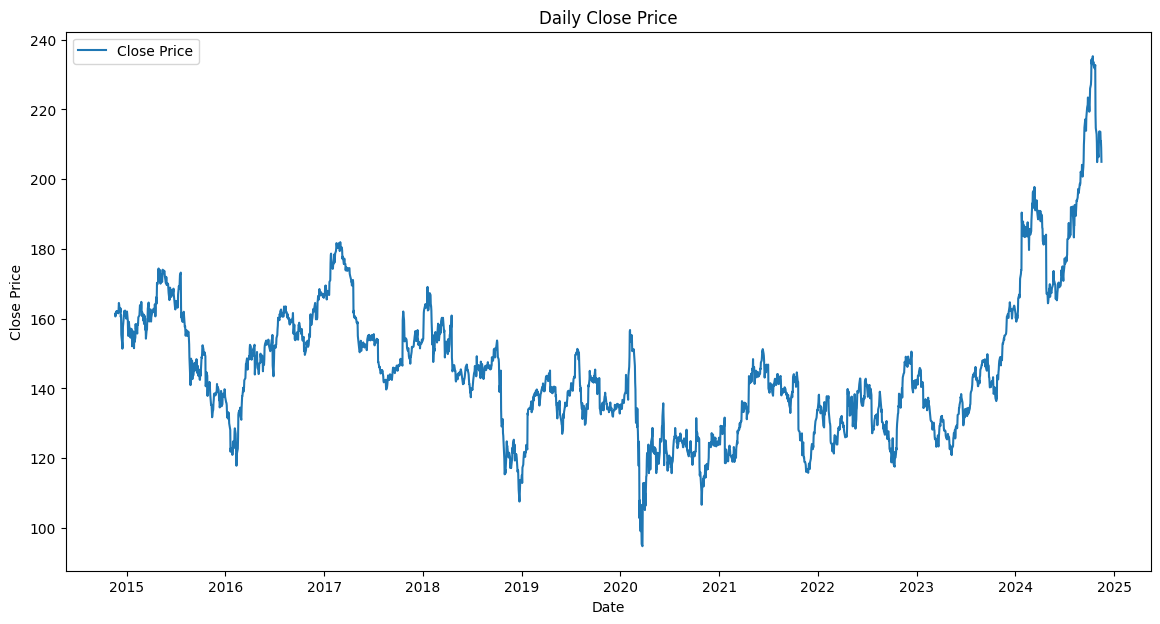

In [7]:
# Visualize the data
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

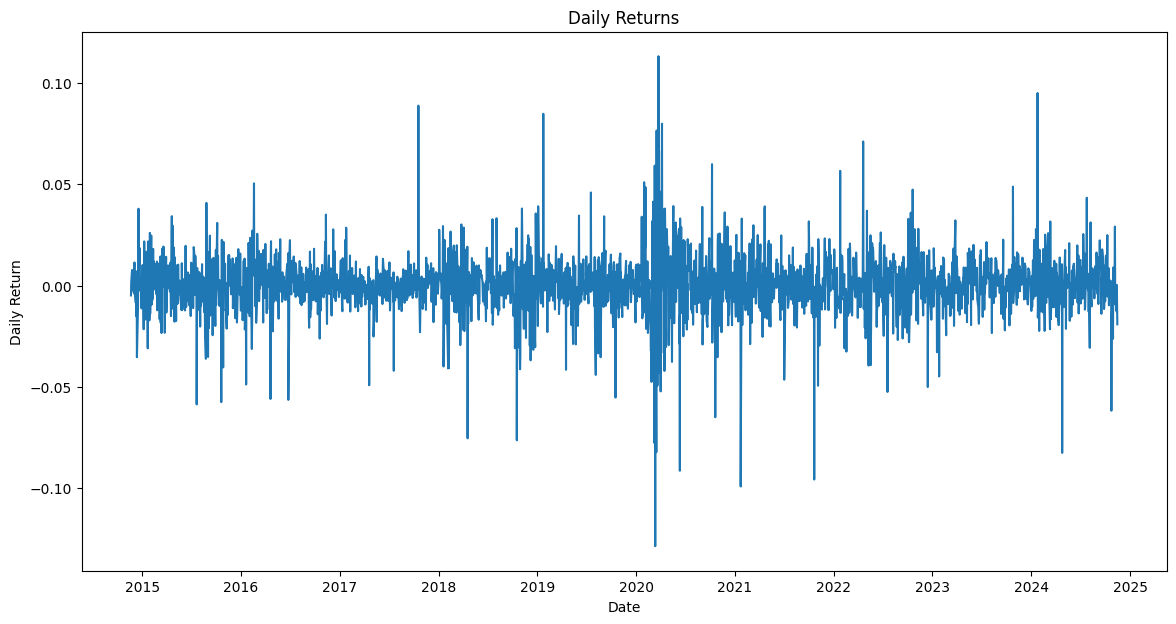

In [8]:
# Calculate and plot daily returns
data['Daily_Return'] = data['Close'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(data['Daily_Return'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

<ipython-input-9-5a4c96682c05>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Daily_Return'].dropna(), bins=50, color='purple')


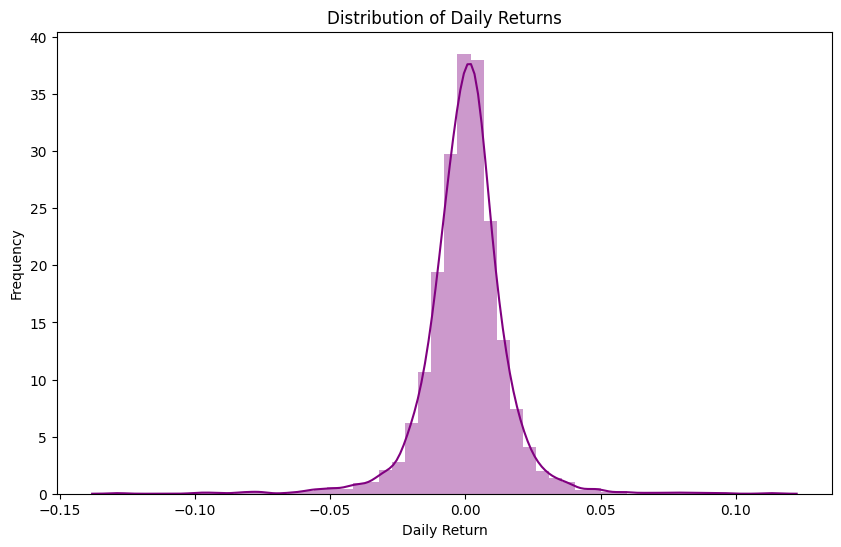

In [9]:
# Distribution plot of daily returns
plt.figure(figsize=(10, 6))
sns.distplot(data['Daily_Return'].dropna(), bins=50, color='purple')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

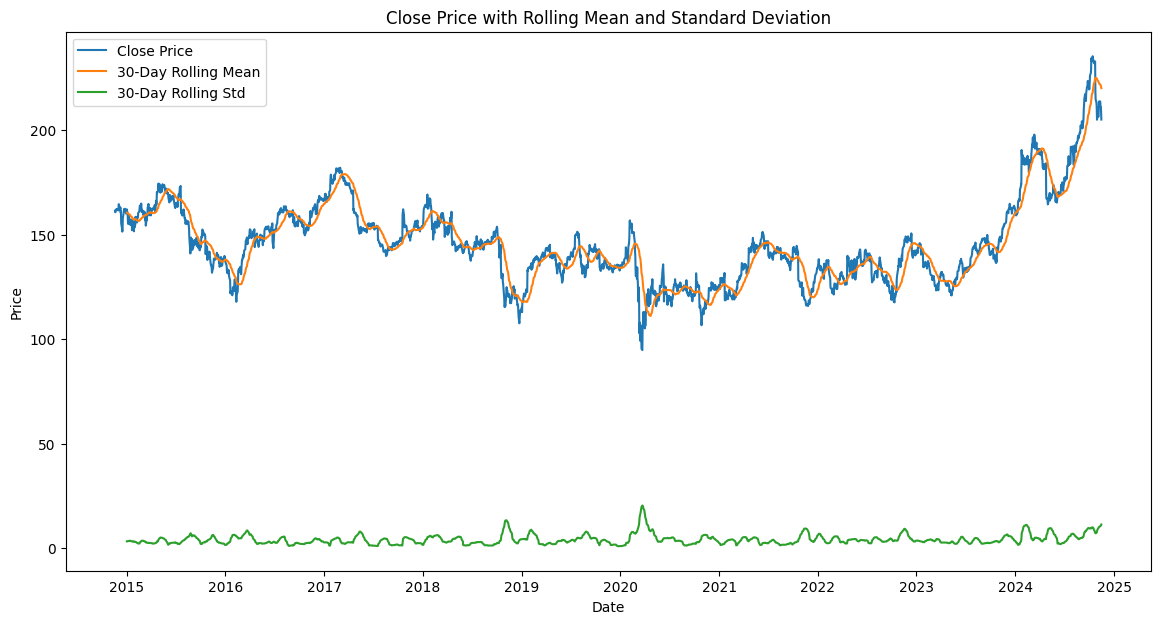

In [10]:
# Rolling mean and standard deviation
data['Rolling_Mean'] = data['Close'].rolling(window=30).mean()
data['Rolling_Std'] = data['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Rolling_Mean'], label='30-Day Rolling Mean')
plt.plot(data['Rolling_Std'], label='30-Day Rolling Std')
plt.title('Close Price with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

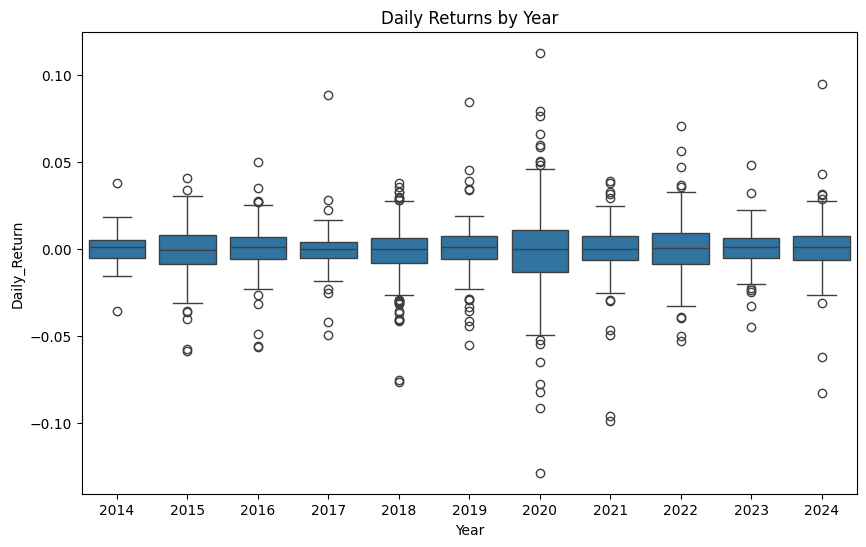

In [11]:
# Box plot of daily returns by year (if you have enough data)
if len(data) >= 365:  # Check if there is enough data
  data['Year'] = pd.DatetimeIndex(data.index).year
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='Year', y='Daily_Return', data=data)
  plt.title('Daily Returns by Year')
  plt.show()
else:
    print("Not enough data points to create the box plot by year.")

# ***Normalizing and creating sequences***

In [12]:
scaler = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())
sequence_length = 60
X, y = [], []
for i in range(len(scaler) - sequence_length):
    X.append(scaler[i:i+sequence_length].values)
    y.append(scaler[i+sequence_length])

X = np.array(X)
y = np.array(y)

print(f"Total sequences: {len(X)}")

<ipython-input-12-0a2e090d8e85>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(scaler[i+sequence_length])


Total sequences: 2455


# ***Model Building***

## ***Activation functions***

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

## ***Mean Absolute Error calculation***

In [14]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

## ***Custom LSTM Class***

In [15]:
class CustomLSTM:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Initialize the LSTM with the required hyperparameters.
        # input_size: Dimensionality of input features.
        # hidden_size: Number of hidden units in the LSTM.
        # output_size: Dimensionality of output predictions.
        # learning_rate: The learning rate for gradient descent.

        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Initialize weights and biases for the gates and output layer.
        # LSTM gates (f, i, o, c) have weights for both the previous hidden state (h) and the current input (x).
        # Weights for gates (f: forget gate, i: input gate, c: candidate cell state, o: output gate)
        # Also initialize biases for each gate and the output layer.
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))

        # Weight matrix for the final output layer that converts hidden state to output size.
        self.Wy = np.random.randn(output_size, hidden_size) * 0.01
        self.by = np.zeros((output_size, 1))

    def forward(self, x):

        # Initialize the previous hidden state (h) and cell state (c).
        # h_prev, c_prev: The initial hidden and cell states are set to zero.
        h_prev, c_prev = np.zeros((self.hidden_size, 1)), np.zeros((self.hidden_size, 1))

        # Cache to store intermediate variables for backpropagation
        self.cache = []

        # Loop through the input sequence.
        for t in range(x.shape[0]):
            # Concatenate the previous hidden state (h_prev) with the current input (x[t]).
            combined = np.vstack((h_prev, x[t:t+1].reshape(-1, 1)))

            # Compute the forget gate, input gate, candidate cell state, and output gate.
            ft = sigmoid(np.dot(self.Wf, combined) + self.bf)  # Forget gate
            it = sigmoid(np.dot(self.Wi, combined) + self.bi)  # Input gate
            c_tilde = tanh(np.dot(self.Wc, combined) + self.bc)  # Candidate cell state
            c_prev = ft * c_prev + it * c_tilde  # Update cell state

            ot = sigmoid(np.dot(self.Wo, combined) + self.bo)  # Output gate
            h_prev = ot * tanh(c_prev)  # New hidden state

            # Store all intermediate values in the cache for backpropagation
            self.cache.append((combined, ft, it, c_tilde, c_prev, ot, h_prev))

        # Calculate the output by using the final hidden state.
        y_pred = np.dot(self.Wy, h_prev) + self.by  # Final prediction (output)
        return y_pred.flatten()  # Flatten to return a 1D array

    def backward(self, dy):
        # Gradients of output layer
        dWy = np.dot(dy.reshape(-1, 1), self.cache[-1][5].reshape(1, -1))
        dby = dy.reshape(-1, 1)

        # Gradient w.r.t hidden state from the output layer.
        dh = np.dot(self.Wy.T, dy.reshape(-1, 1))
        dc_next = np.zeros((self.hidden_size, 1))  # Gradient of cell state for the next timestep

        # Initialize gradients for the LSTM parameters.
        dWf, dWi, dWc, dWo = np.zeros_like(self.Wf), np.zeros_like(self.Wi), np.zeros_like(self.Wc), np.zeros_like(self.Wo)
        dbf, dbi, dbc, dbo = np.zeros_like(self.bf), np.zeros_like(self.bi), np.zeros_like(self.bc), np.zeros_like(self.bo)

        # Perform Backpropagation Through Time (BPTT)
        for t in reversed(range(len(self.cache))):
            combined, ft, it, c_tilde, c_prev, ot, h_prev = self.cache[t]

            # Gradient of the output gate
            dh += np.dot(self.Wy.T, dy.reshape(-1, 1))
            do = dh * tanh(c_prev) * ot * (1 - ot)

            # Gradient of the cell state
            dc = dh * ot * (1 - tanh(c_prev) ** 2) + dc_next  # Derivative of tanh applied to cell state
            dc_tilde = dc * it
            dc_tilde_raw = dc_tilde * (1 - c_tilde ** 2)  # Derivative of tanh applied to candidate cell state

            # Gradient of the input gate
            di = dc * c_tilde
            di_raw = di * it * (1 - it)

            # Gradient of the forget gate
            df = dc * c_prev if t != 0 else dc * 0  # No previous cell state at the first time step
            df_raw = df * ft * (1 - ft)

            # Accumulate gradients for weights and biases
            dWf += np.dot(df_raw, combined.T)
            dWi += np.dot(di_raw, combined.T)
            dWc += np.dot(dc_tilde_raw, combined.T)
            dWo += np.dot(do, combined.T)

            dbf += df_raw
            dbi += di_raw
            dbc += dc_tilde_raw
            dbo += do

            # Gradient w.r.t combined input (h_prev, x[t])
            dcombined = (
                np.dot(self.Wf.T, df_raw) +
                np.dot(self.Wi.T, di_raw) +
                np.dot(self.Wc.T, dc_tilde_raw) +
                np.dot(self.Wo.T, do)
            )

            # Split the gradient into the hidden state (dh_next) and the cell state (dc_next)
            dh_next = dcombined[:self.hidden_size, :]
            dc_next = dc * ft  # Next time step's cell state gradient is based on the forget gate.

        # Update the weights and biases using gradient descent.
        self.Wf -= self.learning_rate * dWf
        self.Wi -= self.learning_rate * dWi
        self.Wc -= self.learning_rate * dWc
        self.Wo -= self.learning_rate * dWo
        self.bf -= self.learning_rate * dbf
        self.bi -= self.learning_rate * dbi
        self.bc -= self.learning_rate * dbc
        self.bo -= self.learning_rate * dbo

    def train_step(self, x, y):
        # Forward pass
        y_pred = self.forward(x)

        # Compute the loss (Mean Squared Error)
        loss = 0.5 * (y_pred - y) ** 2

        # Compute the gradient of the loss w.r.t the output
        dy = y_pred - y

        # Backward pass to update the parameters
        self.backward(dy)

        return loss, y_pred

# ***Initializing LSTM & Training loop***

In [16]:
input_size = 1
hidden_size = 50
output_size = 1
learning_rate = 0.001
epochs = 5

lstm = CustomLSTM(input_size, hidden_size, output_size, learning_rate=learning_rate)


total_loss = 0
total_mae = 0
for epoch in range(epochs):
    total_loss = 0
    total_mae = 0
    for i in range(len(X)):
        loss, y_pred = lstm.train_step(X[i].reshape(-1, 1), y[i])
        total_loss += loss
        total_mae += abs(y[i] - y_pred[0])
    avg_loss = total_loss.mean() / len(X)
    avg_mae = total_mae / len(X)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.5f}, MAE: {avg_mae:.5f}")

Epoch 1/5, Loss: 0.01175, MAE: 0.10417
Epoch 2/5, Loss: 0.00941, MAE: 0.09913
Epoch 3/5, Loss: 0.00931, MAE: 0.09850
Epoch 4/5, Loss: 0.00920, MAE: 0.09770
Epoch 5/5, Loss: 0.00905, MAE: 0.09663


## ***Evaluation***

In [17]:
# Evaluate on training data
predictions = []
for i in range(len(X)):
    y_pred = lstm.forward(X[i].reshape(-1, 1))
    predictions.append(y_pred)

In [18]:
# Reverse scaling for visualization
y_true = data['Close'].values[sequence_length:]  # Adjusting for the sequence length
y_true_scaled = (y_true - y_true.min()) / (y_true.max() - y_true.min())

predictions = np.array(predictions).flatten()
predictions_scaled = (predictions - predictions.min()) / (predictions.max() - predictions.min())

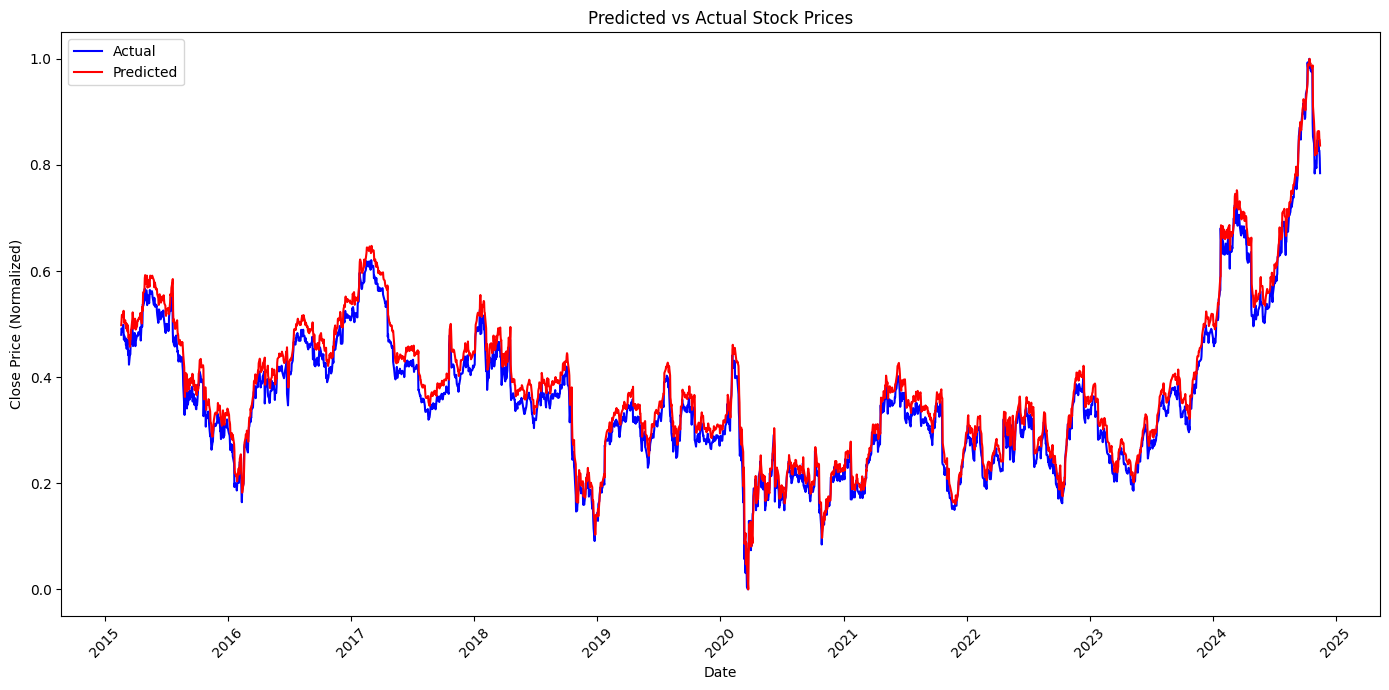

In [19]:
# Plot predicted vs actual with correct date indexing
plt.figure(figsize=(14, 7))

# Use the original date index shifted by the sequence length
date_index = data.index[sequence_length:]
plt.plot(date_index, y_true_scaled, label='Actual', color='blue')
plt.plot(date_index, predictions_scaled, label='Predicted', color='red')

plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (Normalized)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## ***Predicting Stock `close price` For Next Day***

In [20]:
# Prepare the input sequence for prediction
last_sequence = scaler[-sequence_length:].values.reshape(-1, 1)
# Make the prediction
next_day_prediction = lstm.forward(last_sequence)

In [21]:
# Reverse the scaling to get the actual price
next_day_price = next_day_prediction * (data['Close'].max() - data['Close'].min()) + data['Close'].min()
# Get the date for the next day
last_date = pd.to_datetime(data.index[-1])
next_day_date = last_date + pd.DateOffset(days=1)
print(f"Predicted closing price for {next_day_date.strftime('%Y-%m-%d')}: {next_day_price[0]}")

Predicted closing price for 2024-11-16: 151.4046844974934


# ***HyperParameter Tuning***

In [22]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_size': [25, 50, 75],
    'learning_rate': [0.0005, 0.001, 0.005],
    'epochs': [10, 20, 30]
}

best_params = None
best_mae = float('inf')

In [ ]:
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Initialize the CustomLSTM with current hyperparameters
    input_size = 1
    output_size = 1
    lstm = CustomLSTM(input_size, params['hidden_size'], output_size, learning_rate=params['learning_rate'])

    # Training Loop
    for epoch in range(params['epochs']):
        total_loss = 0
        total_mae = 0
        for i in range(len(X)):
            loss, y_pred = lstm.train_step(X[i].reshape(-1, 1), y[i])
            total_loss += loss
            total_mae += abs(y[i] - y_pred[0])
        avg_loss = total_loss.mean() / len(X)
        avg_mae = total_mae / len(X)
        print(f"Epoch {epoch + 1}/{params['epochs']}, Loss: {avg_loss:.5f}, MAE: {avg_mae:.5f}")

    # Evaluation
    predictions = []
    for i in range(len(X)):
        y_pred = lstm.forward(X[i].reshape(-1, 1))
        predictions.append(y_pred)
    predictions = np.array(predictions).flatten()
    mae = np.mean(np.abs(y - predictions))  # Calculate MAE on the training set for this parameter configuration

    print(f"MAE for this configuration: {mae}")

    # Update best parameters if current MAE is lower
    if mae < best_mae:
        best_mae = mae
        best_params = params
        print("New best parameters found!")

Training with parameters: {'epochs': 10, 'hidden_size': 25, 'learning_rate': 0.0005}
Epoch 1/10, Loss: 0.02950, MAE: 0.18722
Epoch 2/10, Loss: 0.02084, MAE: 0.15415
Epoch 3/10, Loss: 0.02064, MAE: 0.15319
Epoch 4/10, Loss: 0.02058, MAE: 0.15286
Epoch 5/10, Loss: 0.02054, MAE: 0.15271
Epoch 6/10, Loss: 0.02052, MAE: 0.15261
Epoch 7/10, Loss: 0.02051, MAE: 0.15255
Epoch 8/10, Loss: 0.02050, MAE: 0.15251
Epoch 9/10, Loss: 0.02050, MAE: 0.15248
Epoch 10/10, Loss: 0.02049, MAE: 0.15245
MAE for this configuration: 0.15244279306324526
New best parameters found!
Training with parameters: {'epochs': 10, 'hidden_size': 25, 'learning_rate': 0.001}
Epoch 1/10, Loss: 0.04491, MAE: 0.25794
Epoch 2/10, Loss: 0.04006, MAE: 0.24281
Epoch 3/10, Loss: 0.03996, MAE: 0.24241
Epoch 4/10, Loss: 0.03993, MAE: 0.24228
Epoch 5/10, Loss: 0.03991, MAE: 0.24222
Epoch 6/10, Loss: 0.03990, MAE: 0.24218
Epoch 7/10, Loss: 0.03990, MAE: 0.24216
Epoch 8/10, Loss: 0.03989, MAE: 0.24214
Epoch 9/10, Loss: 0.03989, MAE: 0.2

## ***Checking the Best MAE and Parameters***

In [ ]:
print(f"\nBest Hyperparameters: {best_params}")
print(f"Best MAE: {best_mae}")

## ***Saving the HyperParameters and Model***

In [ ]:
# Save the model
with open('/content/drive/MyDrive/projects&aProjects/A_Projects/LSTM_without_libraries/lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm, f)

In [ ]:
# Save the best hyperparameters
with open('/content/drive/MyDrive/projects&aProjects/A_Projects/LSTM_without_libraries/best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

## ***Loading the Parameters and Model***

In [ ]:
with open('/content/drive/MyDrive/projects&aProjects/A_Projects/LSTM_without_libraries/lstm_model.pkl', 'rb') as f:
    lstm = pickle.load(f)

with open('/content/drive/MyDrive/projects&aProjects/A_Projects/LSTM_without_libraries/best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

## ***Evaluation***

In [ ]:
# Reverse scaling for visualization
y_true = data['Close'].values[sequence_length:]  # Adjusting for the sequence length
y_true_scaled = (y_true - y_true.min()) / (y_true.max() - y_true.min())

best_predictions_scaled = (predictions - predictions.min()) / (predictions.max() - predictions.min())

In [ ]:
# Plot predicted vs actual with correct date indexing
plt.figure(figsize=(14, 7))

# Use the original date index shifted by the sequence length
date_index = data.index[sequence_length:]
plt.plot(date_index, y_true_scaled, label='Actual', color='blue')
plt.plot(date_index, best_predictions_scaled, label='Predicted', color='red')

plt.title('Predicted vs Actual Stock Prices (Best Model)')
plt.xlabel('Date')
plt.ylabel('Close Price (Normalized)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## ***Predicting Stock `close price` For Next Day***

In [ ]:
sequence_length = 60

In [ ]:
last_sequence = scaler[-sequence_length:].values.reshape(-1, 1)

# Make the prediction
next_day_prediction = lstm.forward(last_sequence)

# Reverse the scaling to get the actual price
next_day_price = next_day_prediction * (data['Close'].max() - data['Close'].min()) + data['Close'].min()

# Get the date for the next day
last_date = pd.to_datetime(data.index[-1])
next_day_date = last_date + pd.DateOffset(days=1)

print(f"Predicted closing price for {next_day_date.strftime('%Y-%m-%d')}: {next_day_price[0]}")